### BATMAN DATASET
#### Name: Dayanara Lebron Aldea
#### Class: STA137
#### Professor:Mr. Prubir

Data set containes daily average receipts per theater for the movie Batman.  
Goal: Estimate the trend, seasonal components, model the stationary part and check how well the estimated model is able to do forecasting.

In [337]:
library('readxl')
batman<-read_excel("batman.xlsx", sheet=1,col_names=FALSE)
colnames(batman)<-c("Avg.Recp","Month","Day.of.Week")
#Retrieve month
batman['Month']<-format(batman$Month,'%B')
batman['Month']<-as.factor(batman$Month)
batman['Day.of.Week']<-as.factor(batman$Day.of.Week)
n=dim(batman)[1]
t=seq(1,n,1)
batman=cbind(batman,t)
head(batman)
str(batman)

Avg.Recp,Month,Day.of.Week,t
3300,June,Wed,1
3285,June,Thu,2
3022,June,Fri,3
2899,June,Sat,4
3995,June,Sun,5
5053,July,Mon,6


'data.frame':	119 obs. of  4 variables:
 $ Avg.Recp   : num  3300 3285 3022 2899 3995 ...
 $ Month      : Factor w/ 5 levels "August","July",..: 3 3 3 3 3 2 2 2 2 2 ...
 $ Day.of.Week: Factor w/ 7 levels "Fri","Mon","Sat",..: 7 5 1 3 4 2 6 7 5 1 ...
 $ t          : num  1 2 3 4 5 6 7 8 9 10 ...


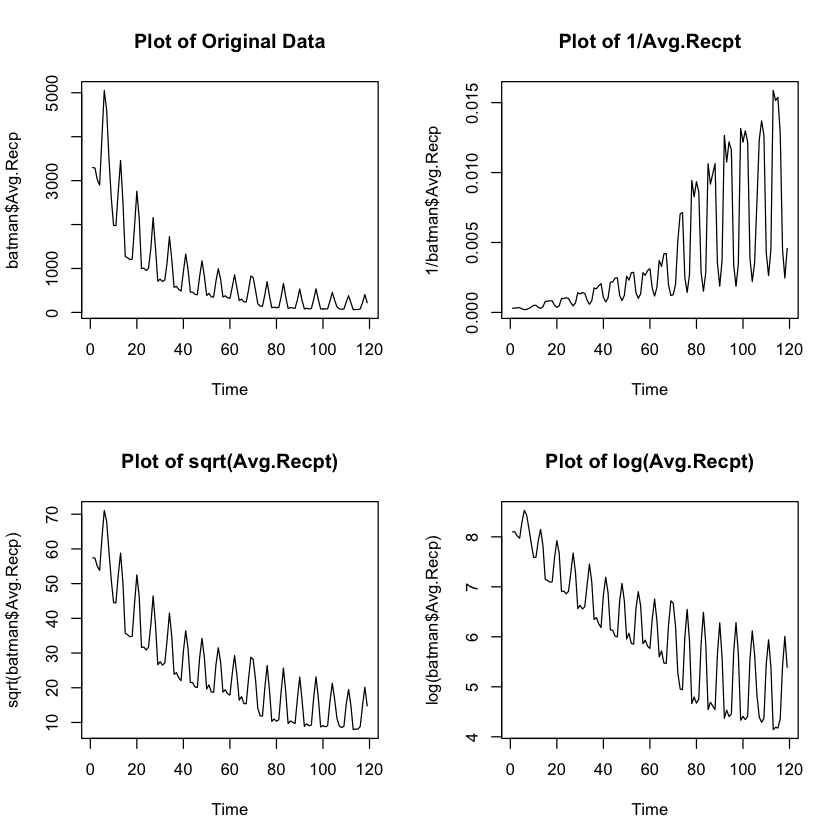

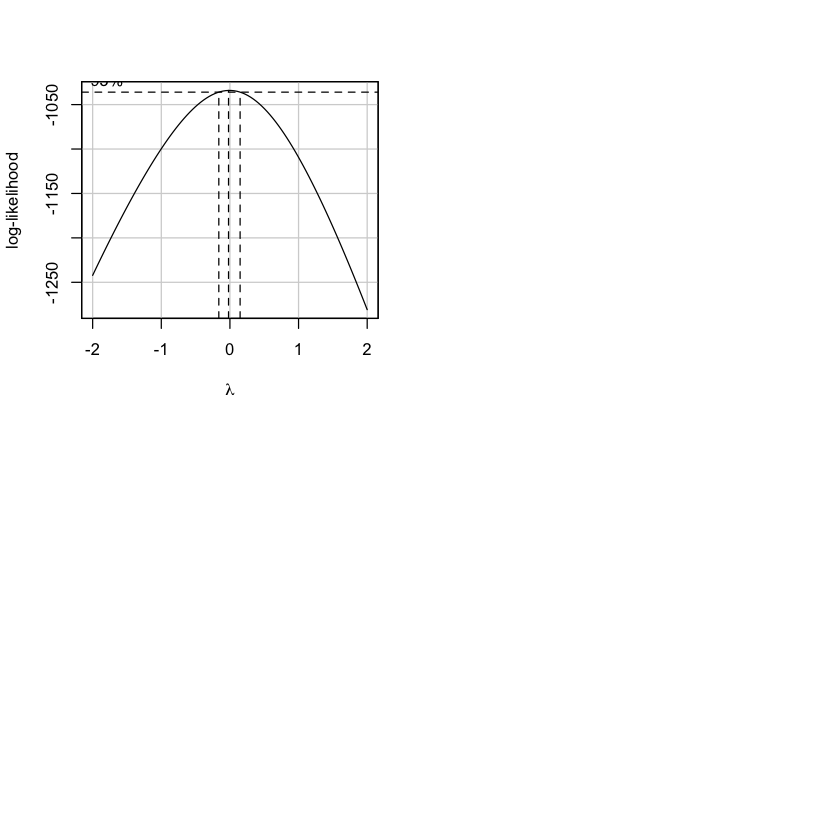

In [338]:
par(mfrow=c(2,2))
plot.ts(batman$Avg.Recp,main="Plot of Original Data")
plot.ts(1/batman$Avg.Recp, main="Plot of 1/Avg.Recpt")
plot.ts(sqrt(batman$Avg.Recp),main="Plot of sqrt(Avg.Recpt)")
plot.ts(log(batman$Avg.Recp),main="Plot of log(Avg.Recpt)")

#SQRT of the data is chosen as the transformed
trans.y=log(y)
car::boxCox(y~1)

The model that goes better with this data is $$Y_t=m_t+s_t+X_t$$  where $m_t$ is the trend (monthly), $s_t$ is the seasonality (daily sales) and $X_t$ is the stationary rough (noise).

In [339]:
#we will model the trend with a cuadratic polynomial
X_trend = cbind(rep(1, n), (1:n)/n, ((1:n)/n)^2)
##coding for seasonality(day of the week)
sn=batman$Day.of.Week
X_s=factor(sn,levels=unique(sn),ordered=TRUE)

#Matrix with 7 days of the week
X_season=model.matrix(~X_s-1)
X_ind=X_season[,1:6]-matrix(rep(X_season[,7],6),ncol=6,nrow=nrow(X_season),byrow=FALSE)

X=cbind(X_trend,X_ind)
colnames(X)[1:3]<-c("1","t","t_2")
head(X)

,1,t,t_2,X_sWed,X_sThu,X_sFri,X_sSat,X_sSun,X_sMon
1,1,0.008403361,7.061648e-05,1,0,0,0,0,0
2,1,0.016806723,2.824659e-04,0,1,0,0,0,0
3,1,0.025210084,6.355483e-04,0,0,1,0,0,0
4,1,0.033613445,1.129864e-03,0,0,0,1,0,0
5,1,0.042016807,1.765412e-03,0,0,0,0,1,0
6,1,0.050420168,2.542193e-03,0,0,0,0,0,1


In [340]:
#Use least squares methods to estimate the beta parameters
xx=t(X)%*%X
xy=t(X)%*%trans.y
beta_hat=solve(xx,xy) #trend plus seasonal
fitted=X%*%beta_hat
rough=trans.y-fitted
head(beta_hat)

1,8.3435627
t,-5.9197482
t_2,2.3683396
X_sWed,-0.3719758
X_sThu,-0.3849351
X_sFri,-0.4815060


In [341]:
ssto=(n-1)*var(trans.y)
sse=t(rough)%*%rough
rsq=1-sse/ssto

rsq #0.9598. #Retry with quadratic and then choose lambda that gives the higest R-Squared; la
#R-squared with quadratic gives same r-squared 0.9599

0.9598009


In [342]:
source('trndseas.R')

In [343]:
trend=X_trend%*%beta_hat[1:3]
season=c(beta_hat[4:9],-sum(beta_hat[4:9]))
head(trend)

8.293984
8.244740
8.195831
8.147255
8.099015
8.051109


[1] 0.9598009

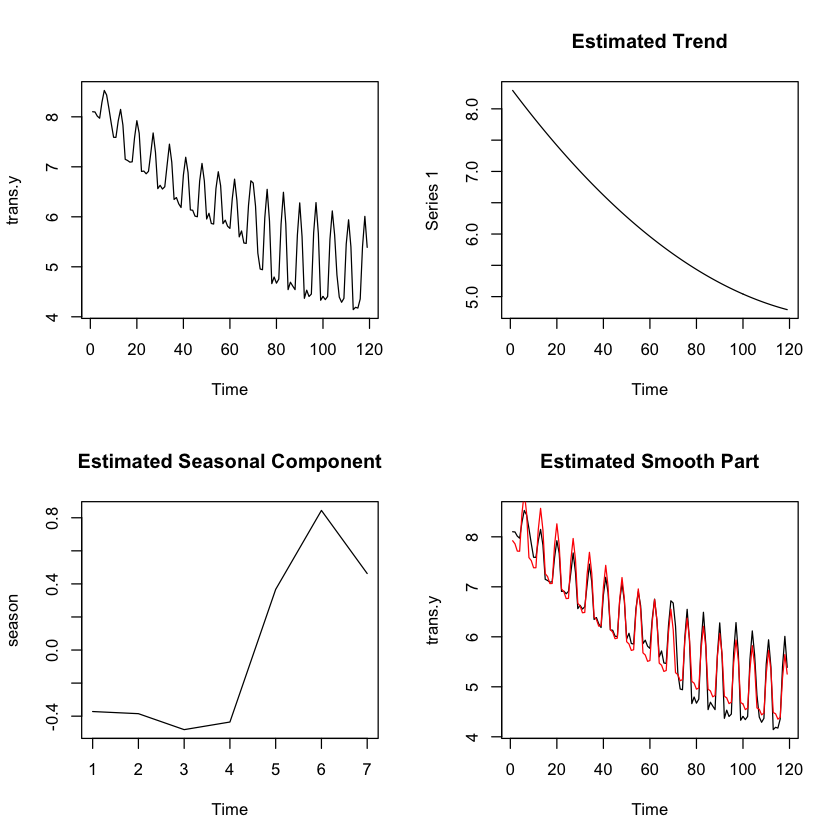

In [344]:
mod0=trndseas(y,seas=7,lam=0,degtrnd=2)
trend.fit=mod0$trend
season.fit=rep(mod0$season,length.out=n)
mod0$rsq
par(mfrow=c(2,2))
plot.ts(trans.y)
plot.ts(trend, main='Estimated Trend')
plot.ts(season,main='Estimated Seasonal Component')
plot.ts(trans.y,main='Estimated Smooth Part')
points(fitted,type='l',col='red')

1,0.1796694
2,0.2373169
3,0.2993496
4,0.2602738
5,-0.1729943
6,-0.3677113


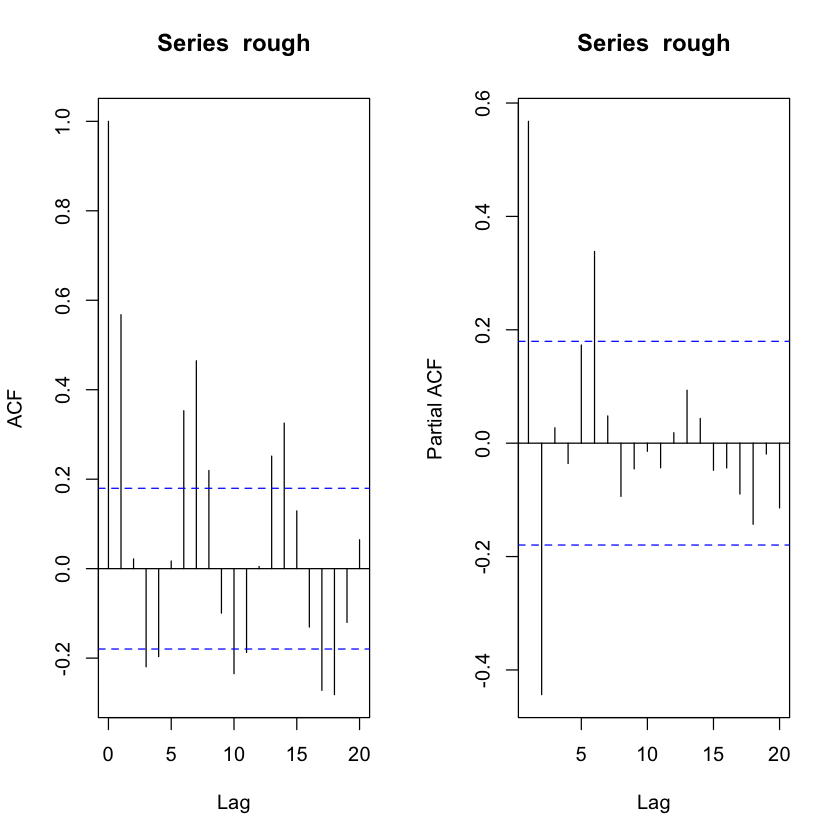

In [345]:
#Initial inspection ofroughs

head(rough)
par(mfrow=c(1,2))
acf(rough) #becomes insignificant after lag=7
pacf(rough) #becomes insignificant after lag=2

In [346]:
#Fit several models
fitAR1=arima(rough,order=c(1,0,0))
fitAR2=arima(rough,order=c(2,0,0))
fitAR7=arima(rough,order=c(7,0,0))
fitMA1=arima(rough,order=c(0,0,1))
fitMA2=arima(rough,order=c(0,0,2))
fitMA7=arima(rough,order=c(0,0,7))
fitARMA11=arima(rough,order=c(1,0,1))
fitARMA21=arima(rough,order=c(2,0,1))
fitARMA22=arima(rough,order=c(2,0,2))
fitARMA27=arima(rough,order=c(2,0,7))
fitARMA72=arima(rough,order=c(7,0,2))
fitARMA12=arima(rough,order=c(1,0,2))


In [347]:
#we select one that for which AIC is the minimum. 
source('aicc.R')

aicc(fitAR1)
aicc(fitAR2)
aicc(fitAR7)
aicc(fitARMA11)
aicc(fitARMA21)
aicc(fitARMA22)
aicc(fitARMA27)#461.87
aicc(fitARMA72) #460.88 first best
aicc(fitARMA12)
aicc(fitMA1)
aicc(fitMA2)
aicc(fitMA7)

#Based on AICC the best model is a ARMA(7,2) model as well as a ARMA(2,7) as second best.


[1] -51.30677

[1] -74.88401

[1] -84.50957

[1] -68.93093

[1] -72.82196

[1] -70.7553

[1] -85.06664

[1] -84.40068

[1] -70.59783

[1] -64.62795

[1] -72.22771

[1] -70.22959

ar1          ar2          ar3          ar4          ar5          ar6 
 1.918876441 -1.966370259  1.129388130 -0.473265346  0.107239645  0.193029875 
         ar7          ma1          ma2    intercept 
-0.148027584 -1.228343356  0.759075566 -0.003354298

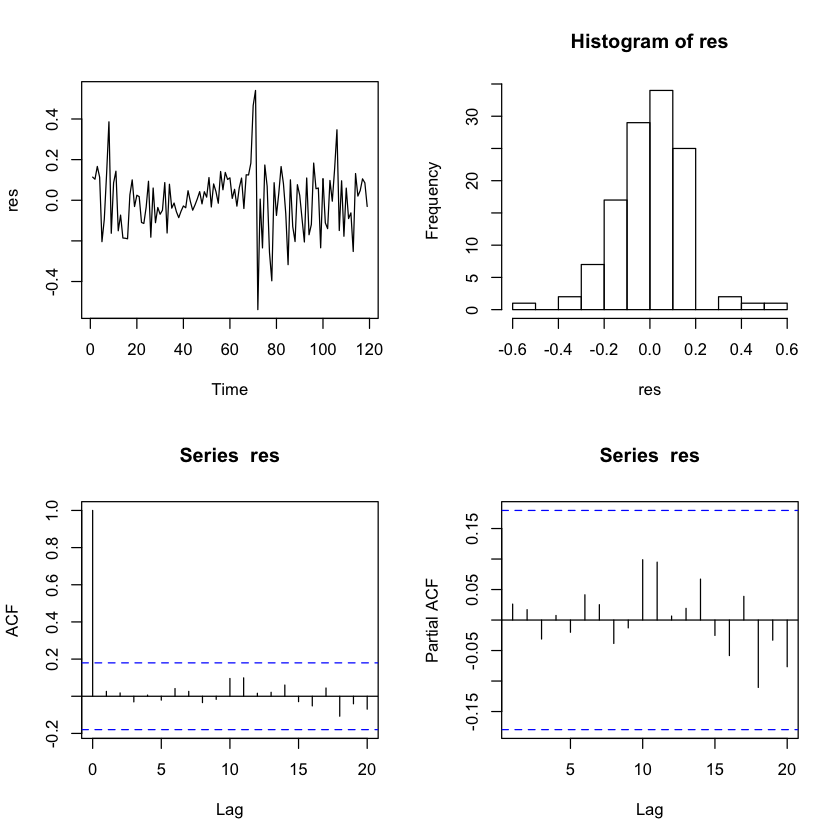

In [348]:
mod1=fitARMA72 #ARMA is not a stationary model but AR is.
mod1$coef

par(mfrow=c(2,2))
res=mod1$res
plot(res)
hist(res)
acf(res) #all lags are non-significant which means that model is the correct one
pacf(res) #same for pacf


In [349]:
#Other AR models

p=seq(0,7,1)
ls=rep(0,7)
for( i in 1:length(p)){
    ls[p[i]+1]=aicc(arima(rough,order=c(p[i],0,0)))
    
}
ls

#AR(3) gives the minimum AIC of 464.609

#AR(6) for quadratic with -86.1359686671592

[1]  -7.013381 -51.306768 -74.884014 -72.804896 -70.795719 -72.114339 -86.135969
[8] -84.509568

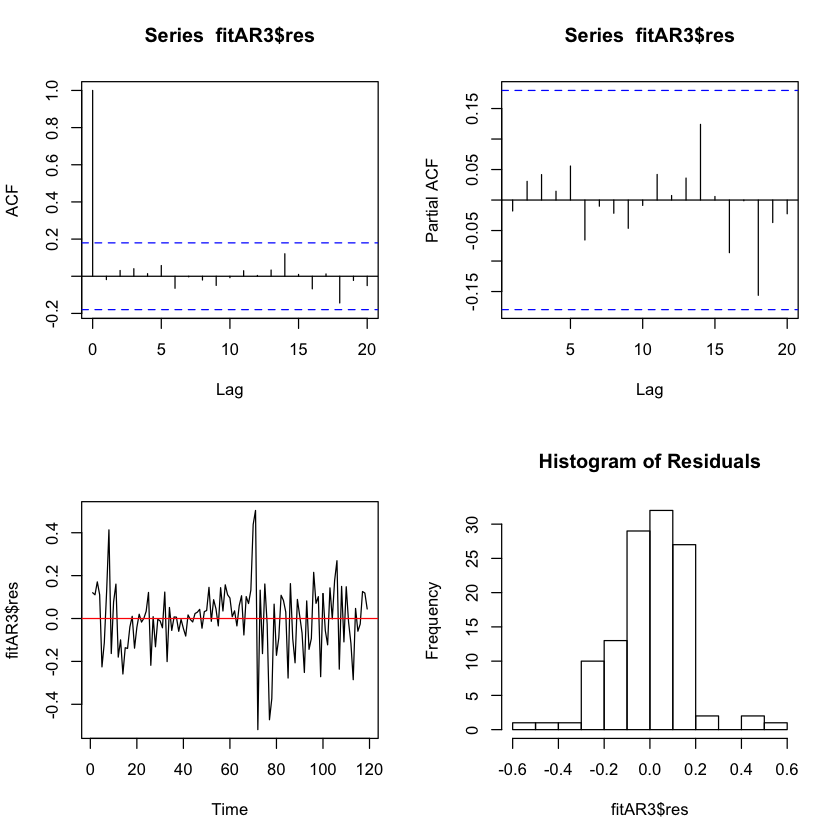

In [350]:
#The minimal AR(p) model of the ones observed was AR(3) with a AIC of 468.62
#lets look the residuals for AR(7)
par(mfrow=c(2,2))
fitAR3=arima(rough,order=c(6,0,0)) #CHANGEEE
#fitAR3=arima(rough,order=c(3,0,0))
acf(fitAR3$res) #residuals resemble white noise fluctuating around mean 0
pacf(fitAR3$res) #residuals look alright
plot(fitAR3$res)
abline(h=0,col="red")
hist(fitAR3$res,main="Histogram of Residuals")


In [351]:
#Test independence using Box-Ljung Test

Box.test(fitAR3$res,lag=10,'Ljung-Box') #We accept H0 of independence and therefore the residuals are white nise



	Box-Ljung test

data:  fitAR3$res
X-squared = 1.7133, df = 10, p-value = 0.9981


In [352]:
#Test equality of variance


### Forecasting

Using your estimated model, predict the last 7 seven days using observations
from the rst 112 days. Plot the observed as well as the predicted values for the
last seven days. [It is better to use linear extrapolation rather than a polynomial
one.]

In [353]:

model<-lm(trans.y[1:112]~X[1:112,])
summary(model) #.9602


Call:
lm(formula = trans.y[1:112] ~ X[1:112, ])

Residuals:
     Min       1Q   Median       3Q      Max 
-0.46888 -0.18373  0.01518  0.15751  0.91056 

Coefficients: (1 not defined because of singularities)
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)       8.33896    0.06910 120.671  < 2e-16 ***
X[1:112, ]1            NA         NA      NA       NA    
X[1:112, ]t      -5.89729    0.33577 -17.563  < 2e-16 ***
X[1:112, ]t_2     2.35109    0.34253   6.864 5.16e-10 ***
X[1:112, ]X_sWed -0.35129    0.05542  -6.338 6.23e-09 ***
X[1:112, ]X_sThu -0.36876    0.05540  -6.656 1.39e-09 ***
X[1:112, ]X_sFri -0.47118    0.05539  -8.507 1.51e-13 ***
X[1:112, ]X_sSat -0.43435    0.05538  -7.842 4.26e-12 ***
X[1:112, ]X_sSun  0.35160    0.05539   6.348 5.96e-09 ***
X[1:112, ]X_sMon  0.82071    0.05540  14.814  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2393 on 103 degrees of freedom
Multiple R-squared:  0.9581

In [354]:
#Comparison of betas of model with first 112 obs vs full obs
cbind(model$coefficients[-2],beta_hat)


(Intercept),8.3389552,8.3435627
"X[1:112, ]t",-5.8972902,-5.9197482
"X[1:112, ]t_2",2.3510915,2.3683396
"X[1:112, ]X_sWed",-0.3512908,-0.3719758
"X[1:112, ]X_sThu",-0.3687611,-0.3849351
"X[1:112, ]X_sFri",-0.4711836,-0.4815060
"X[1:112, ]X_sSat",-0.4343465,-0.4354081
"X[1:112, ]X_sSun",0.3515991,0.3667783
"X[1:112, ]X_sMon",0.8207056,0.8443400


In [355]:
#Forecasting the trend 
h=7
deg=2
n=112
coefficients=model$coefficients[-2]
coef=coefficients[1:3]
time=(n+(1:h))/n; time


[1] 1.008929 1.017857 1.026786 1.035714 1.044643 1.053571 1.062500

In [356]:
predmat = matrix(rep(time,deg)^rep(1:deg,each=h),nrow=h,byrow=FALSE)
predmat = cbind(rep(1,h),predmat); predmat

1,1.008929,1.017937
1,1.017857,1.036033
1,1.026786,1.054289
1,1.035714,1.072704
1,1.044643,1.091279
1,1.053571,1.110013
1,1.062500,1.128906


In [357]:
m.fc = predmat %*% coef
season= c(coefficients[4:9],-sum(coefficients[4:9]))
s.fc = rep(season,length.out=n+h)
s.fc = s.fc[-(1:n)]

In [358]:
rough_fitted=trans.y[1:112]-model$fitted
m_rough=arima(rough_fitted,order=c(3,0,0))
fcast=predict(m_rough,n.ahead=h)
x.fc=fcast$pred
x.fc

Time Series:
Start = 113 
End = 119 
Frequency = 1 
[1] -0.0349423258 -0.0546523540 -0.0260331833  0.0014693574  0.0100791173
[6]  0.0058303097 -0.0003792741

In [359]:
y.fc = m.fc + s.fc + x.fc
y.fc

Time Series:
Start = 113 
End = 119 
Frequency = 1 
         [,1]
[1,] 4.396040
[2,] 4.348752
[3,] 4.265215
[4,] 4.320196
[5,] 5.105767
[6,] 5.562016
[7,] 5.180144

In [360]:
x.fc

Time Series:
Start = 113 
End = 119 
Frequency = 1 
[1] -0.0349423258 -0.0546523540 -0.0260331833  0.0014693574  0.0100791173
[6]  0.0058303097 -0.0003792741

In [361]:
s.fc

X[1:112, ]X_sWed X[1:112, ]X_sThu X[1:112, ]X_sFri X[1:112, ]X_sSat 
      -0.3512908       -0.3687611       -0.4711836       -0.4343465 
X[1:112, ]X_sSun X[1:112, ]X_sMon                  
       0.3515991        0.8207056        0.4532773

In [362]:
y.fc = m.fc + s.fc + x.fc


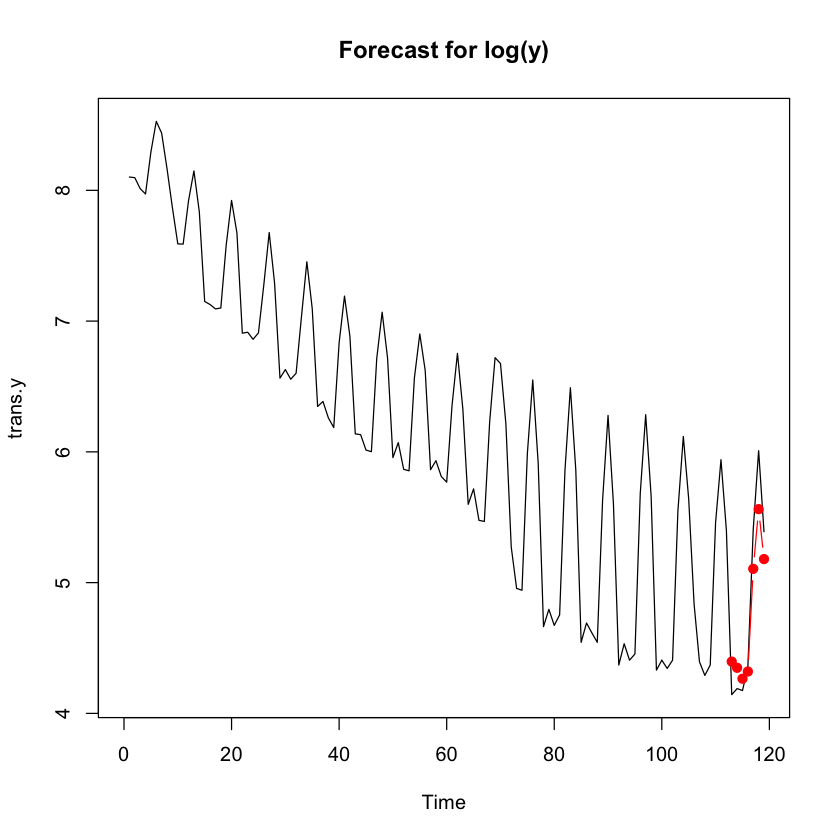

In [363]:
plot.ts(trans.y,xlim=c(0,n+h))
points(x=n+1:h,y=y.fc,col="red",type='b',pch=19)
title("Forecast for log(y)")


In [364]:
diff=trans.y[113:119]-y.fc[1:7]

In [365]:
compare<-cbind(y.fc[1:7],trans.y[113:119],diff)
colnames(compare)<-c("fitted","actual","difference")

In [366]:
y.fc[1:7]

[1] 4.396040 4.348752 4.265215 4.320196 5.105767 5.562016 5.180144

In [367]:
trans.y[113:119]

[1] 4.143135 4.189655 4.174387 4.356709 5.407172 6.008813 5.389072

In [368]:
trans.y[113:119]-y.fc[1:7]

[1] -0.25290547 -0.15909684 -0.09082746  0.03651308  0.30140439  0.44679695
[7]  0.20892742

In [326]:
#Differences for log are smaller than when using Squared transformation.
#In report put both.

[1] 119   4